In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import polyphase
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

from autograd import hessian, jacobian, grad
import autograd.numpy as anp

In [3]:
def get_data(index):
    data_dict = {0:{'M':[5,5,1],'chi':[1,0.5,0.5]},
                 1:{'M':[64,1,1],'chi':[1,0.3,0.2]}   
    }
    
    M = data_dict[index]['M']
    chi = data_dict[index]['chi']
    
    return M, chi
    
M,chi = get_data(1)

In [4]:
# get phase diagram and compare
fh = lambda x: polyphase.flory_huggins(x,M,chi)
engine = polyphase.PHASE(fh,100,3)
engine.compute(use_parallel=False, verbose=False, lift_label=True)
df = engine.df.T

Computation took 5.67s


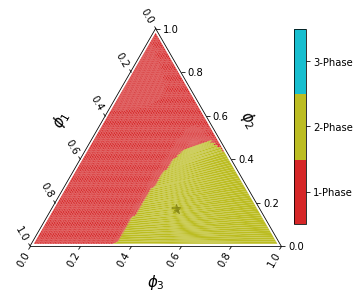

In [5]:
p1,p2,p3,l = df[df['label']==2].sample().values[0]
ternplot = polyphase.TernaryPlot(engine)
ax, _ = ternplot.plot_simplices()
ax.scatter(p3,p1,p2,color='k',marker='*',s=100)
plt.show()

In [6]:
def f12(x):
    x1,x2 = x
    x3 = anp.abs(1-x1-x2).astype(float)
    entropy = (x1*anp.log(x1))/M[0] + (x2*anp.log(x2))/M[1] + (x3*anp.log(x3))/M[2]
    enthalpy = chi[0]*x1*x2 + chi[1]*x1*x3 + chi[2]*x2*x3
    
    return entropy+enthalpy

def f13(x):
    x1,x3 = x
    x2 = anp.abs(1-x1-x3).astype(float)
    entropy = (x1*anp.log(x1))/M[0] + (x2*anp.log(x2))/M[1] + (x3*anp.log(x3))/M[2]
    enthalpy = chi[0]*x1*x2 + chi[1]*x1*x3 + chi[2]*x2*x3
    
    return entropy+enthalpy

def f23(x):
    x2,x3 = x
    x1 = anp.abs(1-x2-x3).astype(float)
    entropy = (x1*anp.log(x1))/M[0] + (x2*anp.log(x2))/M[1] + (x3*anp.log(x3))/M[2]
    enthalpy = chi[0]*x1*x2 + chi[1]*x1*x3 + chi[2]*x2*x3
    
    return entropy+enthalpy

lsa = polyphase.LSA(M,chi,f=f12)

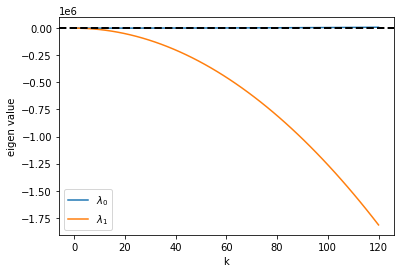

Is the point stable: False


In [7]:
x0 = np.asarray([p1,p2])
lsa.evaluate(x0)
lsa.plot()
print('Is the point stable: {}'.format(lsa.is_stable(x0)))

In [13]:
isstable = []
for _, row in df.iterrows():
    p1,p2,_ = row.loc[[True,True,False,True]].values
    x0 = np.asarray([p1,p2])
    isstable.append(lsa.is_stable(x0))
    break
    
isstable = np.asarray(isstable, dtype=bool)

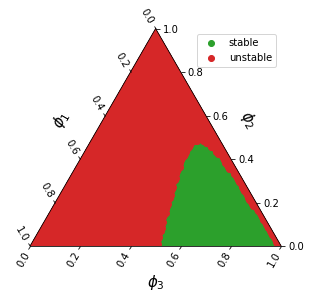

In [17]:
stable = df[isstable]
fig,ax = plt.subplots(subplot_kw={'projection':'ternary'})
ax.scatter(stable['Phi_3'],stable['Phi_1'],stable['Phi_2'],color='tab:green',label='stable')
unstable = df[~isstable]
ax.scatter(unstable['Phi_3'],unstable['Phi_1'],unstable['Phi_2'],color='tab:red', label='unstable')
polyphase._set_axislabels_mpltern(ax)
ax.legend()
plt.show()